In [1]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import PIL
import numpy as np

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import tensorflow_datasets as tfds

In [3]:
import pathlib

In [4]:
dataset_url = pathlib.Path().absolute()/'flower_photos'

In [7]:
builder = tfds.folder_dataset.ImageFolder(dataset_url)

In [5]:
dataset_root = os.path.abspath('./'+'flower_photos.tgz')

In [10]:
data_dir

PosixPath('/Users/DPRS/.keras/datasets/flower_photos')

In [7]:
data_dir = tf.keras.utils.get_file("flower_photos", origin = 'file://'+dataset_root, untar=True)

In [42]:
# builder.info

In [9]:
data_dir = pathlib.Path(data_dir)

In [11]:
image_count = len(list(data_dir.glob('*/*.jpg')))

In [12]:
image_count

3670

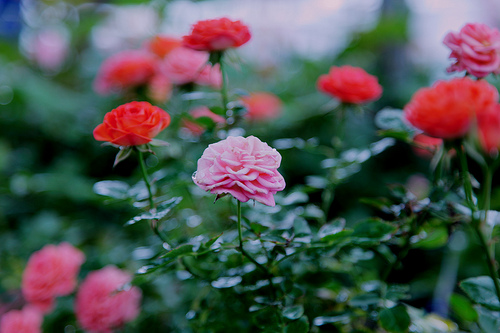

In [37]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

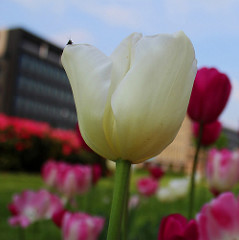

In [41]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[1]))

In [43]:
batch_size = 32
img_height = 180
img_width = 180

In [45]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [48]:
class_name = train_ds.class_names
print(class_name)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [50]:
train_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

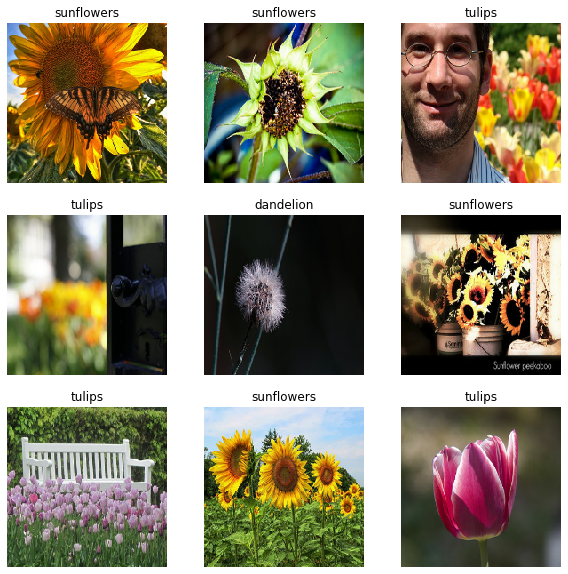

In [52]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_name[labels[i]])
    plt.axis("off")

In [53]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [54]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [55]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [56]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0034399498 1.0


In [57]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [58]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [61]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 58s 622ms/step - loss: 1.3051 - accuracy: 0.4431 - val_loss: 1.0779 - val_accuracy: 0.5681
Epoch 2/10
92/92 [==============================] - 58s 623ms/step - loss: 0.9967 - accuracy: 0.6165 - val_loss: 1.0235 - val_accuracy: 0.5967
Epoch 3/10
92/92 [==============================] - 57s 621ms/step - loss: 0.7858 - accuracy: 0.7033 - val_loss: 1.0705 - val_accuracy: 0.5872
Epoch 4/10
92/92 [==============================] - 56s 604ms/step - loss: 0.5716 - accuracy: 0.7939 - val_loss: 0.9715 - val_accuracy: 0.6376
Epoch 5/10
92/92 [==============================] - 57s 618ms/step - loss: 0.3609 - accuracy: 0.8730 - val_loss: 1.0765 - val_accuracy: 0.6567
Epoch 6/10
92/92 [==============================] - 56s 613ms/step - loss: 0.1863 - accuracy: 0.9390 - val_loss: 1.1345 - val_accuracy: 0.6771
Epoch 7/10
92/92 [==============================] - 58s 628ms/step - loss: 0.1191 - accuracy: 0.9636 - val_loss: 1.3311 - val_accuracy: 0.6580

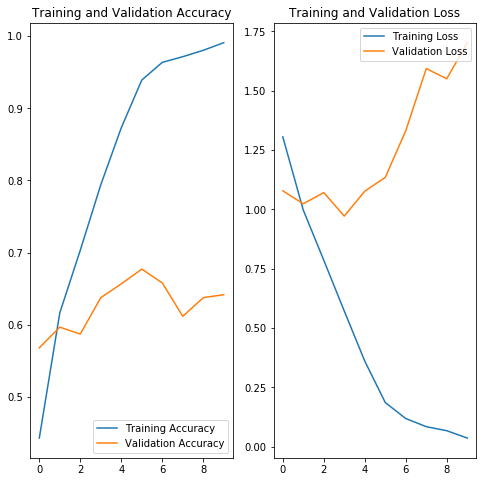

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [63]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

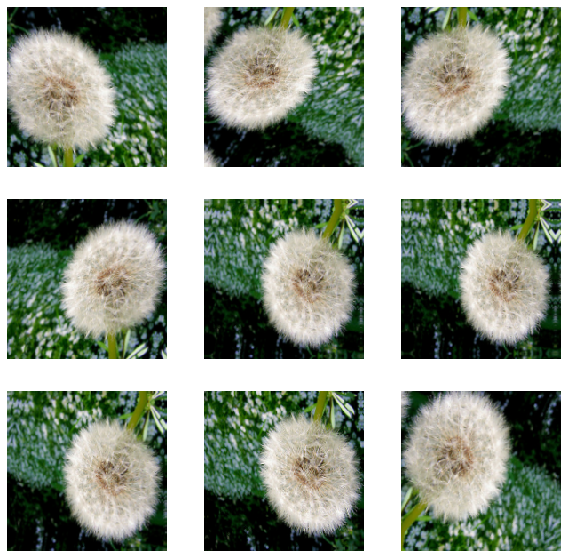

In [64]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [65]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [66]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [67]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [68]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 64s 677ms/step - loss: 1.2223 - accuracy: 0.4710 - val_loss: 1.0724 - val_accuracy: 0.5736
Epoch 2/15
92/92 [==============================] - 64s 692ms/step - loss: 1.0441 - accuracy: 0.5848 - val_loss: 1.0997 - val_accuracy: 0.5668
Epoch 3/15
92/92 [==============================] - 64s 691ms/step - loss: 0.9493 - accuracy: 0.6104 - val_loss: 0.8800 - val_accuracy: 0.6417
Epoch 4/15
92/92 [==============================] - 64s 696ms/step - loss: 0.8586 - accuracy: 0.6621 - val_loss: 0.9745 - val_accuracy: 0.6390
Epoch 5/15
92/92 [==============================] - 62s 669ms/step - loss: 0.8319 - accuracy: 0.6792 - val_loss: 0.7921 - val_accuracy: 0.6935
Epoch 6/15
92/92 [==============================] - 62s 675ms/step - loss: 0.7928 - accuracy: 0.6907 - val_loss: 0.7966 - val_accuracy: 0.6921
Epoch 7/15
92/92 [==============================] - 62s 674ms/step - loss: 0.7601 - accuracy: 0.7023 - val_loss: 0.7798 - val_accuracy: 0.7003

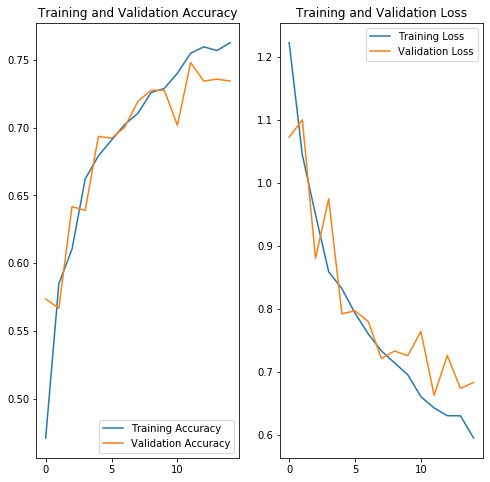

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [94]:
# sun_url = 'file://'+test_root+'/Sunflower/sun2.jpeg'
# sunflower_path = tf.keras.utils.get_file('sun2', origin=sun_url) 

# rose_url = 'file://'+test_root+'/Rose/rose1.jpeg'
# rose_path = tf.keras.utils.get_file('rose1', origin=rose_url) 

dan_url = 'file://'+test_root+'/Dandelion/dan2.jpeg'
dan_path = tf.keras.utils.get_file('dan2', origin=dan_url)

img = keras.preprocessing.image.load_img(
    dan_path, target_size=(img_height, img_width) 
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array) 
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_name[np.argmax(score)], 100 * np.max(score))
)

16384/9922 [=================================================] - 0s 0us/step
This image most likely belongs to dandelion with a 71.11 percent confidence.


In [73]:
test_root = os.path.abspath('./'+'Test/')

In [74]:
test_root

'/Users/DPRS/Documents/Python/Image_clas/Test'

In [84]:
score

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([3.5269808e-05, 1.1950491e-06, 4.5354888e-01, 4.4238354e-06,
       5.4641020e-01], dtype=float32)>